In [6]:
import os
import json
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# Unzipping your Data.zip file from Google Drive "My Drive" folder into the Colab environment
print("Unzipping Data.zip from Google Drive...")
!unzip -q "/content/drive/My Drive/Data.zip" -d /content/
print("Unzipping complete.")

Mounted at /content/drive
Unzipping Data.zip from Google Drive...
Unzipping complete.


In [9]:
DATASET_PATH = "genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc_robust(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """
    A more robust version of the MFCC extraction function with extra debugging.
    """
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = int(np.ceil(samples_per_segment / hop_length))

    print(f"--- Starting Robust Feature Extraction from: {dataset_path} ---")

    # Loop through all the genre folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # Use a more robust path comparison and ensure it's not the root directory
        if dirpath != dataset_path:
            # Save the semantic label (genre name)
            semantic_label = os.path.basename(dirpath)
            data["mapping"].append(semantic_label)

            # Process all audio files in the genre sub-folder
            wav_files = [f for f in filenames if f.endswith('.wav')]
            if not wav_files:
                continue

            print(f"\nProcessing {semantic_label}: Found {len(wav_files)} .wav files.")

            for f in wav_files:
                file_path = os.path.join(dirpath, f)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_per_segment * s
                        finish_sample = start_sample + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            # Correct label index (0-9)
                            data["labels"].append(len(data["mapping"]) - 1)
                except Exception as e:
                    print(f"    [ERROR] Could not process {file_path}: {e}")

    print("\n--- Feature Extraction Summary ---")
    if not data["mfcc"]:
        print("❌ CRITICAL: No data was extracted. The JSON file will be empty.")
    else:
        print(f"✅ SUCCESS: Extracted {len(data['mfcc'])} MFCC segments for {len(data['mapping'])} genres.")

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {json_path}")

# Run the robust feature extraction
save_mfcc_robust(DATASET_PATH, JSON_PATH, num_segments=10)

--- Starting Robust Feature Extraction from: genres_original ---

Processing disco: Found 100 .wav files.

Processing hiphop: Found 100 .wav files.

Processing blues: Found 100 .wav files.

Processing classical: Found 100 .wav files.

Processing rock: Found 100 .wav files.

Processing reggae: Found 100 .wav files.

Processing pop: Found 100 .wav files.

Processing metal: Found 100 .wav files.

Processing country: Found 100 .wav files.

Processing jazz: Found 100 .wav files.


/tmp/ipython-input-9-1691523919.py:41: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


    [ERROR] Could not process genres_original/jazz/jazz.00054.wav: 

--- Feature Extraction Summary ---
✅ SUCCESS: Extracted 9986 MFCC segments for 10 genres.
Data saved to data.json


Training data shape: (7988, 130, 13, 1)
y_train shape: (7988,)
Test data shape: (1998, 130, 13, 1)
y_test shape: (1998,)
Class mapping: ['disco', 'hiphop', 'blues', 'classical', 'rock', 'reggae', 'pop', 'metal', 'country', 'jazz']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,202 (688.29 KB)

 Trainable params: 175,754 (686.54 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2627 - loss: 2.3428 - val_accuracy: 0.4910 - val_loss: 1.4750
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4539 - loss: 1.5362 - val_accuracy: 0.5606 - val_loss: 1.2265
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5360 - loss: 1.2964 - val_accuracy: 0.6126 - val_loss: 1.1157
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5981 - loss: 1.1459 - val_accuracy: 0.6431 - val_loss: 1.0274
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6279 - loss: 1.0553 - val_accuracy: 0.6496 - val_loss: 0.9931
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6647 - loss: 0.9477 - val_accuracy: 0.6632 - val_loss: 0.9590
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6913 - loss: 0.8917 - val_accuracy: 0.6997 - val_loss: 0.8873
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7109 - loss: 0.8295 - val_accuracy: 

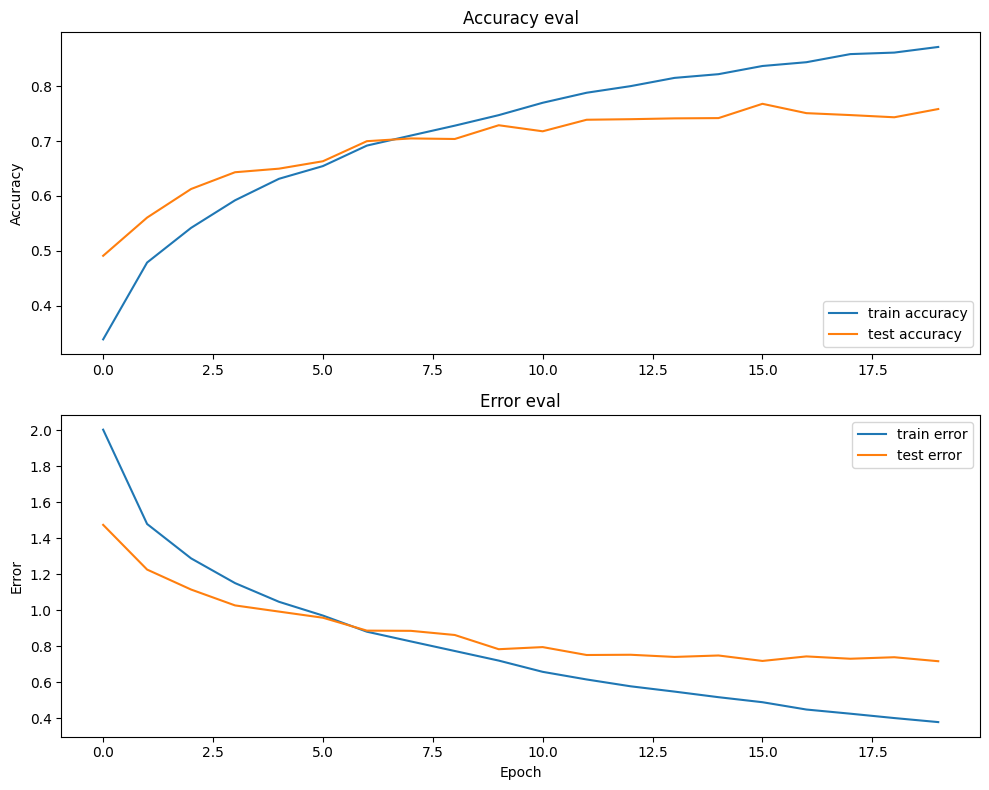

63/63 - 0s - 3ms/step - accuracy: 0.7583 - loss: 0.7174



Test accuracy: 0.758
Model saved as music_genre_classifier.h5


In [10]:
def load_data(json_path):
    """Loading training data"""
    with open(json_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    class_mapping = data["mapping"]

    return X, y, class_mapping

X, y, class_mapping = load_data(JSON_PATH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Class mapping: {class_mapping}")

def build_model(input_shape):
    """CNN model."""
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Flatten output and feed it into a dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax')) # 10 genres

    return model

# Creating model
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# Compiling
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=20) # You can increase epochs for better performance

# Plot accuracy and loss
fig, axs = plt.subplots(2, figsize=(10, 8))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train accuracy')
axs[0].plot(history.history['val_accuracy'], label='test accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Accuracy eval')

# Loss
axs[1].plot(history.history['loss'], label='train error')
axs[1].plot(history.history['val_loss'], label='test error')
axs[1].set_ylabel('Error')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')
axs[1].set_title('Error eval')

plt.tight_layout()
plt.show()

# Evaluating model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.3f}')
# Saving
model.save("music_genre_classifier.h5")
print("Model saved as music_genre_classifier.h5")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,202 (688.29 KB)

 Trainable params: 175,754 (686.54 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.2716 - loss: 2.2777 - val_accuracy: 0.5010 - val_loss: 1.4644
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4791 - loss: 1.4971 - val_accuracy: 0.5721 - val_loss: 1.2047
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5497 - loss: 1.2836 - val_accuracy: 0.6136 - val_loss: 1.1017
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 1.1487 - val_accuracy: 0.6491 - val_loss: 1.0263
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6394 - loss: 1.0214 - val_accuracy: 0.6687 - val_loss: 0.9424
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6717 - loss: 0.9364 - val_accuracy: 0.6872 - val_loss: 0.9149
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6979 - loss: 0.8758 - val_accuracy: 0.7102 - val_loss: 0.8609
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7321 - loss: 0.7883 - val_accuracy: 

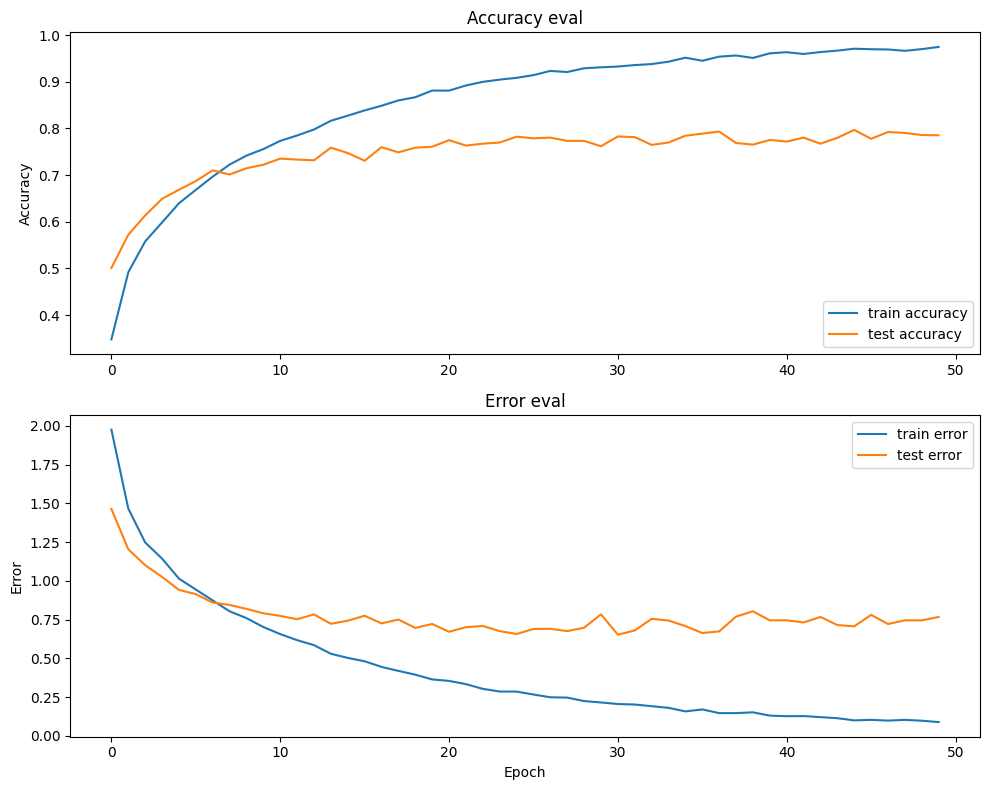

63/63 - 0s - 3ms/step - accuracy: 0.7853 - loss: 0.7678



Test accuracy: 0.785
Model saved as music_genre_classifier.h5


In [11]:
def build_model(input_shape):
    """CNN model."""
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Flatten output and feed it into a dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax')) # 10 genres

    return model

# Creating model
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# Compiling
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=50) # You can increase epochs for better performance

# Plot accuracy and loss
fig, axs = plt.subplots(2, figsize=(10, 8))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train accuracy')
axs[0].plot(history.history['val_accuracy'], label='test accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Accuracy eval')

# Loss
axs[1].plot(history.history['loss'], label='train error')
axs[1].plot(history.history['val_loss'], label='test error')
axs[1].set_ylabel('Error')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')
axs[1].set_title('Error eval')

plt.tight_layout()
plt.show()

# Evaluating model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.3f}')
# Saving
model.save("music_genre_classifier.h5")
print("Model saved as music_genre_classifier.h5")
files.download('music_genre_classifier.h5')

In [15]:
files.download('music_genre_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Please upload an MP3 or WAV file to classify.


Saving 505.mp3 to 505 (2).mp3

File '505 (2).mp3' uploaded successfully.


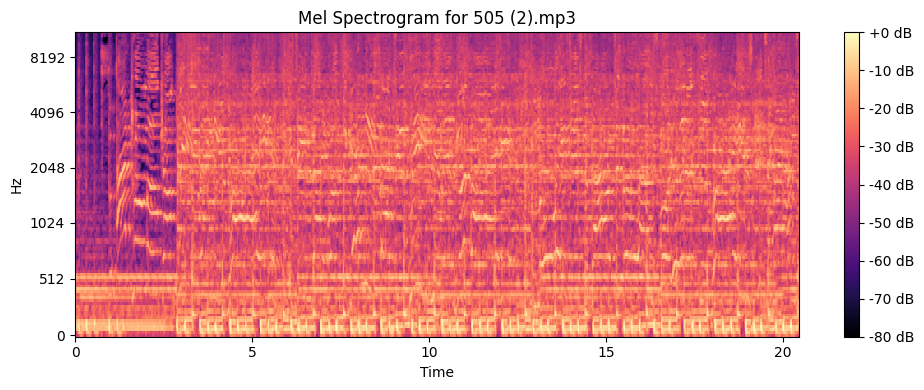

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Predicted Genre: **ROCK**
Confidence: **46.85%**


In [14]:
def predict_genre(model, file_path, class_mapping, num_segments=10):
    """
    Predicts the genre of a single audio file.

    This corrected function ensures that the audio segments are padded or
    truncated to a fixed length before MFCC extraction, guaranteeing a
    consistent input shape for the model.
    """
    # Define constants based on the training configuration
    SAMPLE_RATE = 22050
    DURATION = 30 # seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
    SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK / num_segments)

    # 1. Load audio file
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return

    # 2. Visualize Spectrogram (Optional)
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram for {os.path.basename(file_path)}')
    plt.tight_layout()
    plt.show()

    # 3. Process the audio file in segments
    mfcc_list = []
    for s in range(num_segments):
        start_sample = SAMPLES_PER_SEGMENT * s
        finish_sample = start_sample + SAMPLES_PER_SEGMENT

        # Ensure the segment is the correct length by padding if necessary
        segment = signal[start_sample:finish_sample]
        if len(segment) < SAMPLES_PER_SEGMENT:
            segment = np.pad(segment, (0, SAMPLES_PER_SEGMENT - len(segment)), 'constant')

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc = mfcc.T
        mfcc_list.append(mfcc)

    if not mfcc_list:
        print("Could not extract MFCCs from the audio file.")
        return

    # 4. Convert to numpy array and add dimensions for model input
    mfcc_features = np.array(mfcc_list)
    mfcc_features = mfcc_features[..., np.newaxis]

    # 5. Make prediction
    predictions = model.predict(mfcc_features)

    # 6. Average predictions across segments and find the most likely genre
    avg_prediction = np.mean(predictions, axis=0)
    predicted_index = np.argmax(avg_prediction)
    predicted_genre = class_mapping[predicted_index]
    confidence = avg_prediction[predicted_index]

    print(f"\nPredicted Genre: **{predicted_genre.upper()}**")
    print(f"Confidence: **{confidence:.2%}**")

# Upload your own audio file
print("\nPlease upload an MP3 or WAV file to classify.")
uploaded = files.upload()

if uploaded:
    # Get the file path of the uploaded file
    file_path = next(iter(uploaded))
    print(f"\nFile '{os.path.basename(file_path)}' uploaded successfully.")

    # Predict the genre using the trained model and class mapping
    predict_genre(model, file_path, class_mapping)